In [1]:
import pandas as pd
import pickle

In [2]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

%matplotlib inline

/home/farhaan/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Exploring the Raw DataFrame

In [3]:
student_data_df_raw = pickle.load(open('student_data_df.p',"rb"))

In [4]:
student_data_df_raw.head()

,Hispanic_White_Achievement_Gap,black_students,black_teachers,hispanic_students,hispanic_teachers,school_name,white_students,white_teachers
0,-14.0,26.3,4.1,19.9,4.6,A B SHEPARD HIGH SCH (CAMPUS) (9-12),50.6,90.5
1,-29.0,84.8,21.8,13.9,16.3,ACE TECHNICAL CHARTER HIGH SCHOOL (9-12),1.2,51.4
2,-4.0,2.9,1.6,61.1,4.5,ADDISON TRAIL HIGH SCHOOL (9-12),30.7,86.8
3,-30.0,1.5,0.9,7.6,0.4,ADLAI E STEVENSON HIGH SCHOOL (9-12),63.4,94.2
4,-5.0,42.5,21.8,42.2,16.3,AIR FORCE ACAD HIGH SCHOOL (9-12),11.0,51.4


In [5]:
student_data_df_raw.shape

(228, 8)

In [6]:
student_data_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 8 columns):
Hispanic_White_Achievement_Gap    228 non-null float64
black_students                    228 non-null float64
black_teachers                    228 non-null float64
hispanic_students                 228 non-null float64
hispanic_teachers                 228 non-null float64
school_name                       228 non-null object
white_students                    228 non-null float64
white_teachers                    228 non-null float64
dtypes: float64(7), object(1)
memory usage: 14.3+ KB


# Cleaning the Data

While scraping, the program had stalled twice due to not allowing enough times for elements to load before searching for them. Due to this there were some duplicate rows in the dataframe.

In [7]:
student_data_df_raw.drop_duplicates(inplace=True)

In [8]:
student_data_df_raw.corr()

,Hispanic_White_Achievement_Gap,black_students,black_teachers,hispanic_students,hispanic_teachers,white_students,white_teachers
Hispanic_White_Achievement_Gap,1.000000,-0.166478,-0.168370,0.138470,-0.129539,0.033445,0.210227
black_students,-0.166478,1.000000,0.571722,-0.145378,0.226446,-0.613120,-0.380713
black_teachers,-0.168370,0.571722,1.000000,0.306391,0.710031,-0.680863,-0.840897
hispanic_students,0.138470,-0.145378,0.306391,1.000000,0.599360,-0.651379,-0.431511
hispanic_teachers,-0.129539,0.226446,0.710031,0.599360,1.000000,-0.670874,-0.773703
white_students,0.033445,-0.613120,-0.680863,-0.651379,-0.670874,1.000000,0.650665
white_teachers,0.210227,-0.380713,-0.840897,-0.431511,-0.773703,0.650665,1.000000


In [9]:
y,X1,X2,X3,X4,X5,X6 = list(student_data_df_raw.corr().columns)
(y,X1,X2,X3,X4,X5,X6)

('Hispanic_White_Achievement_Gap',
 'black_students',
 'black_teachers',
 'hispanic_students',
 'hispanic_teachers',
 'white_students',
 'white_teachers')

**Attention!**

Unfortunately, Illinois Report Card did not have data for teacher demographics by school, only by district. So, a large school district like chicago which have schools very diverse in teacher populations from each other will not contribute positively to our model.
Doing a quick check of sorting by the number of entries with identical teacher demographics, yields one row with a much larger count than others. 27 schools are represented by that combination of teacher demographics (21.8,16.3,51.4). The next highest count is 5.

Checking against the public records on the source website confirms that these are schools belonging to the Chicago Public Schools (CPS) system.
To maintain the validity of our data, we should remove all data associated with CPS schools.

In [10]:
print("Total number of schools:",len(student_data_df_raw))
check_large_districts_df = student_data_df_raw.groupby([X2,X4,X6],as_index=False)[y].count()
check_large_districts_df.sort_values([y],ascending=False).head()

Total number of schools: 225


,black_teachers,hispanic_teachers,white_teachers,Hispanic_White_Achievement_Gap
128,21.8,16.3,51.4,27
97,2.2,5.6,88.0,5
109,4.5,2.4,86.2,5
94,2.1,18.6,77.2,5
81,1.3,5.1,88.6,5


In [11]:
len(student_data_df_raw)

225

Below are the schools in the group of 27. A google search will confirm that all of these schools are indeed within CPS.

In [12]:
student_data_df_raw[(student_data_df_raw[X2]==21.8)&(student_data_df_raw[X4]==16.3)&(student_data_df_raw[X6]==51.4)]

,Hispanic_White_Achievement_Gap,black_students,black_teachers,hispanic_students,hispanic_teachers,school_name,white_students,white_teachers
1,-29.0,84.8,21.8,13.9,16.3,ACE TECHNICAL CHARTER HIGH SCHOOL (9-12),1.2,51.4
4,-5.0,42.5,21.8,42.2,16.3,AIR FORCE ACAD HIGH SCHOOL (9-12),11.0,51.4
7,-4.0,11.1,21.8,59.1,16.3,AMUNDSEN HIGH SCHOOL (9-12),12.3,51.4
25,-29.0,80.7,21.8,18.3,16.3,BOWEN HIGH SCHOOL (9-12),0.2,51.4
35,-8.0,41.3,21.8,18.7,16.3,CHICAGO HS FOR AGRICULT SCIENCES (9-12),36.7,51.4
36,-17.0,54.9,21.8,18.2,16.3,CHICAGO VIRTUAL CHARTER SCHOOL (K-12),16.0,51.4
47,-19.0,20.9,21.8,51.2,16.3,DISNEY II MAGNET HS (7-12),21.2,51.4
70,-29.0,57.7,21.8,39.9,16.3,GOODE STEM ACADEMY HS (9-12),1.0,51.4
91,-3.0,5.6,21.8,90.6,16.3,HUBBARD HIGH SCHOOL (9-12),2.8,51.4
94,-25.0,6.7,21.8,83.5,16.3,INTRINSIC CHARTER HIGH SCHOOL (7-12),6.4,51.4


Let's filter out CPS schools from the dataframe

In [13]:
schools_no_cps_df = student_data_df_raw[(student_data_df_raw[X2]!=21.8)&(student_data_df_raw[X4]!=16.3)&(student_data_df_raw[X6]!=51.4)]
print("Total number of schools in new filtered dataframe:",len(schools_no_cps_df))

Total number of schools in new filtered dataframe: 198



[Riverside Brookfield High School](https://www.illinoisreportcard.com/School.aspx?source=teachers&source2=teacherdemographics&Schoolid=060162080170001) has over 98 % of teachers listed as Not reported. This school does not help out data set so we shall remove it and looks odd in the pairplot, so we shall remove it.



In [36]:
schools_no_cps_df = schools_no_cps_df.sort_values('white_teachers').iloc[1:,:]

In [63]:
#Running the correlations between variables again:
schools_no_cps_df.corr()

,Hispanic_White_Achievement_Gap,black_students,black_teachers,hispanic_students,hispanic_teachers,white_students,white_teachers
Hispanic_White_Achievement_Gap,1.000000,0.033317,0.070842,0.179726,0.095537,-0.134110,-0.041263
black_students,0.033317,1.000000,0.738559,-0.132500,-0.027246,-0.612196,-0.416803
black_teachers,0.070842,0.738559,1.000000,0.014532,0.127623,-0.546893,-0.678177
hispanic_students,0.179726,-0.132500,0.014532,1.000000,0.625494,-0.652253,-0.376316
hispanic_teachers,0.095537,-0.027246,0.127623,0.625494,1.000000,-0.509607,-0.578193
white_students,-0.134110,-0.612196,-0.546893,-0.652253,-0.509607,1.000000,0.655184
white_teachers,-0.041263,-0.416803,-0.678177,-0.376316,-0.578193,0.655184,1.000000


Notice that the strongest positive correlations amongst the inputs are:

    - black_students/black_teacher(0.7386)
    - hispanic_students/hispanic_teachers(0.6255)
    - white_students/white_teachers (0.655)

This could possibly indicate:
- a preference of teachers to work with students of a similar ethnic background.
- a preference of administrators to hire teachers that share a common culture with the school's student population.
- a preference of white teachers to not work in schools with high concentrations of minority students (perhaps because these districts have lesser compensation packages compared to more affluent districts or other conditions that are unacceptable)

**Doing a pairplot to visualize multicollinearity.**

Doesn't seem to be too great of of a multicollinearity between any of the inputs of interest. The only thing to note is that we accept the percentage of black teachers plus hispanic teachers should be negatively correlated with the percentage of white teachers since the total percentage of teachers cannot exceed 100%.

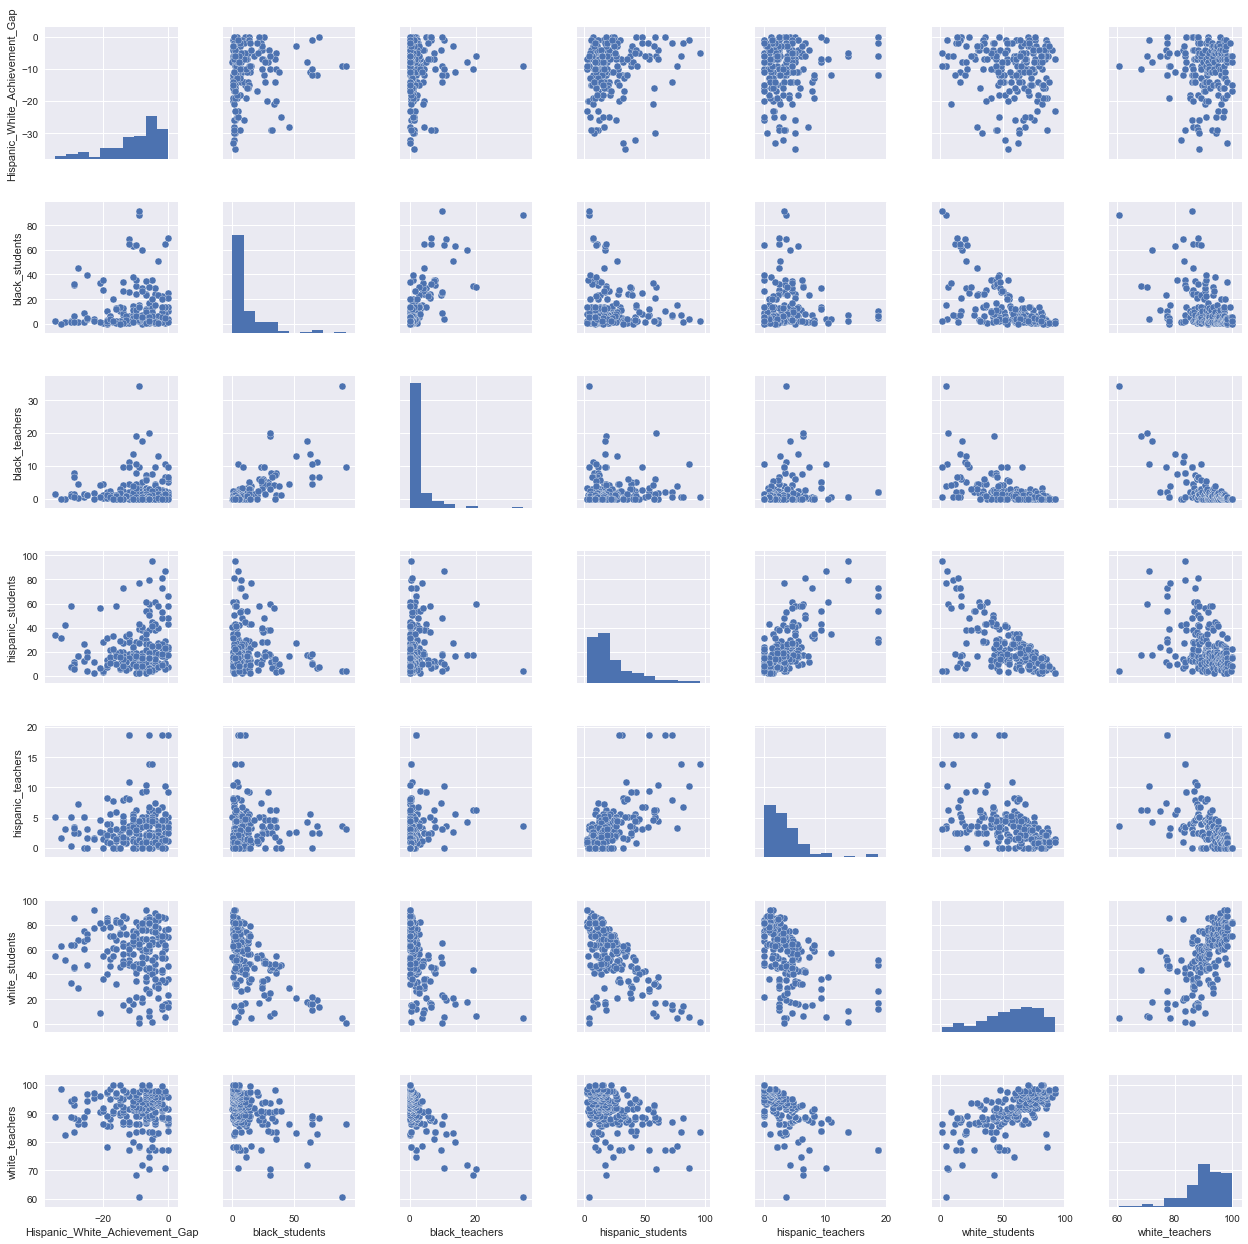

In [64]:
sns.pairplot(schools_no_cps_df)

In [15]:
schools_no_cps_df.columns

Index(['Hispanic_White_Achievement_Gap', 'black_students', 'black_teachers',
       'hispanic_students', 'hispanic_teachers', 'school_name',
       'white_students', 'white_teachers'],
      dtype='object')

In [37]:
# drop school_name column and rename the columns for ease of use
schools_no_name_df = schools_no_cps_df.loc[:,['Hispanic_White_Achievement_Gap', 'black_students', 'black_teachers',
       'hispanic_students', 'hispanic_teachers','white_students', 'white_teachers']]

"""
y : 'Hispanic_White_Achievement_Gap'
X1: 'black_students'
X2: 'black_teachers'
X3: 'hispanic_students'
X4: 'hispanic_teachers'
X5: 'white_students'
X6: 'white_teachers'
"""
schools_no_name_df.columns = ['y','X1','X2','X3','X4','X5','X6']
schools_no_name_df.head()

,y,X1,X2,X3,X4,X5,X6
177,-9.0,88.4,34.3,3.9,3.6,4.8,60.6
54,-10.0,30.4,19.1,17.5,6.3,43.3,68.4
173,-6.0,30.1,20.1,59.5,6.3,6.1,70.4
90,-1.0,4.4,10.5,86.8,10.2,5.3,71.0
22,-8.0,59.8,17.5,17.0,4.3,17.7,72.0


# Exploratory Data Analysis

Let's now run a Ordinary Least Square Linear Regression on the data using statsmodel

In [38]:
# Creating strings of variable names for input into patsy
y_string = list(schools_no_name_df.columns)[0]
X_string = list(schools_no_name_df.columns)[1:]
X_string = ' + '.join(X_string)

In [39]:
y, X = patsy.dmatrices(y_string+' ~ '+X_string, data=schools_no_name_df, return_type="dataframe")
#Performing an 'Ordinary Least Square Regression' on our data
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1.788
Date:                Tue, 25 Jul 2017   Prob (F-statistic):              0.103
Time:                        14:28:58   Log-Likelihood:                -680.18
No. Observations:                 197   AIC:                             1374.
Df Residuals:                     190   BIC:                             1397.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -39.2833     15.655     -2.509      0.013     -70.162      -8.404
X1             0.0676      0.107      0.635      0.526      -0.143       0.278
X2             0.3532      0.268      1.317      0.189      -0.176       0.882
X3             0.1534      0.089      1.716      0.088      -0.023       0.330
X4             0.1310      0.243      0.538      0.591      -0.349       0.611
X5             0.0689      0.098      0.705      0.481      -0.124       0.262
X6             0.2168      0.164      1.320      0.189      -0.107       0.541
==============================================================================
Omnibus:                       29.673   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.924
Skew:                          -1.003   Prob(JB):                     5.82e-09
Kurtosis:                       3.774   Cond. No.                     3.12e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Both the R-Squared (0.059) and the Adjusted R-squared (0.024) are extremely weak. The t-scores seem to indicate that the only variables worth exploring further are \\( X_3 \\) (hisp_students) with \\( P = 0.013 \\).

However, a model with only **X3 (hispanic_students)** as inputs yields an Adj R-squared (=0.027), barely higher but noticably less complicated than the original model.

In [58]:
y, X = patsy.dmatrices(y_string+' ~ '+'X3', data=schools_no_name_df, return_type="dataframe")
#Performing an 'Ordinary Least Square Regression' on our data for Achivement Gap vs %Hispanic Students
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     6.509
Date:                Tue, 25 Jul 2017   Prob (F-statistic):             0.0115
Time:                        14:48:43   Log-Likelihood:                -682.36
No. Observations:                 197   AIC:                             1369.
Df Residuals:                     195   BIC:                             1375.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.9002      0.887    -13.418      0.000     -13.649     -10.151
X3             0.0776      0.030      2.551      0.011       0.018       0.138
==============================================================================
Omnibus:                       33.726   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.087
Skew:                          -1.091   Prob(JB):                     1.62e-10
Kurtosis:                       3.855   Cond. No.                         46.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

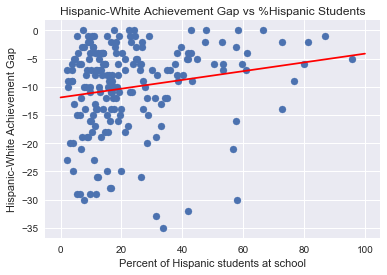

In [62]:
plt.scatter(schools_no_name_df['X3'],schools_no_name_df['y'])
x1_achievement_hisp_students_model = np.linspace(0,100,num=60)
y1_achievement_hisp_students_model = 0.0776*x1_achievement_hisp_students_model - 11.90
plt.title('Hispanic-White Achievement Gap vs %Hispanic Students')
plt.xlabel('Percent of Hispanic students at school')
plt.ylabel('Hispanic-White Achievement Gap')
plt.plot(x1_achievement_hisp_students_model,y1_achievement_hisp_students_model,'r-')
#plt.savefig('achievement_gap_vs_hisp_students.png')

## Points to consider

At this point it seems pretty clear that just having more hispanic teachers in a school doesn't automatically translate to a smaller difference in achievement gap. Thus, recommendations that minority students will do better when they have more minority teachers seem to not be supported by the data.

### Achievement Gap vs Hispanic Teachers

**Ordinary Least Square Regression and Graph**

In [56]:
y, X = patsy.dmatrices(y_string+' ~ '+'X4', data=schools_no_name_df, return_type="dataframe")
#Performing an 'Ordinary Least Square Regression' on our data
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.796
Date:                Tue, 25 Jul 2017   Prob (F-statistic):              0.182
Time:                        14:46:46   Log-Likelihood:                -684.69
No. Observations:                 197   AIC:                             1373.
Df Residuals:                     195   BIC:                             1380.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.9078      0.805    -13.543      0.000     -12.496      -9.319
X4             0.2136      0.159      1.340      0.182      -0.101       0.528
==============================================================================
Omnibus:                       30.030   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.561
Skew:                          -1.045   Prob(JB):                     4.23e-09
Kurtosis:                       3.575   Cond. No.                         7.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

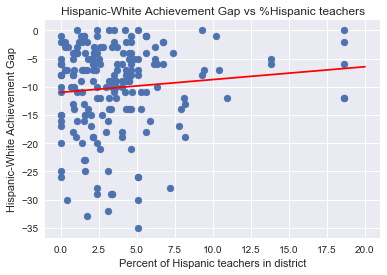

In [57]:
plt.scatter(schools_no_name_df['X4'],schools_no_name_df['y'])
x1_achievement_hisp_teachers_model = np.linspace(0,20,num=60)
y1_achievement_hisp_teachers_model = 0.227*x1_achievement_hisp_teachers_model - 11.002
plt.title('Hispanic-White Achievement Gap vs %Hispanic teachers')
plt.xlabel('Percent of Hispanic teachers in district')
plt.ylabel('Hispanic-White Achievement Gap')
plt.plot(x1_achievement_hisp_teachers_model,y1_achievement_hisp_teachers_model,'r-')
#plt.savefig('achievement_gap_vs_hisp_teachers.png')

**One thing to look at is to look at the total minority teacher population (rather than black and hispanic teachers individually) at a school.**
This can be done by taking 100 minus the white teacher population.

``
Percentage of minority teachers = 100 - Percentage of white teachers
             X7                 = 100 - X6
``

In [44]:
schools_no_name_df['X7'] = 100 - schools_no_name_df['X6']
schools_no_name_df.head()

In [55]:
y, X = patsy.dmatrices(y_string+' ~ '+'X7', data=schools_no_name_df, return_type="dataframe")
#Performing an 'Ordinary Least Square Regression' on our data
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.3326
Date:                Tue, 25 Jul 2017   Prob (F-statistic):              0.565
Time:                        14:41:08   Log-Likelihood:                -685.42
No. Observations:                 197   AIC:                             1375.
Df Residuals:                     195   BIC:                             1381.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.5954      0.981    -10.805      0.000     -12.529      -8.661
X7             0.0492      0.085      0.577      0.565      -0.119       0.217
==============================================================================
Omnibus:                       30.667   Durbin-Watson:                   1.800
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.648
Skew:                          -1.058   Prob(JB):                     2.46e-09
Kurtosis:                       3.592   Cond. No.                         20.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

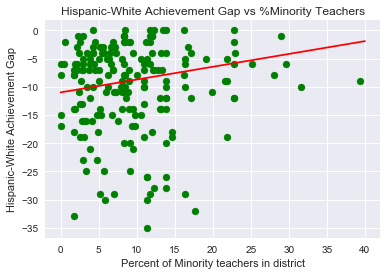

In [54]:
plt.scatter(schools_no_name_df['X7'],schools_no_name_df['y'],c='g')
x1_achievement_hisp_teachers_model = np.linspace(0,40,num=60)
y1_achievement_hisp_teachers_model = 0.227*x1_achievement_hisp_teachers_model - 11.002
plt.title('Hispanic-White Achievement Gap vs %Minority Teachers')
plt.xlabel('Percent of Minority teachers in district')
plt.ylabel('Hispanic-White Achievement Gap')
plt.plot(x1_achievement_hisp_teachers_model,y1_achievement_hisp_teachers_model,'r-')
#plt.savefig('achievement_gap_vs_hisp_teachers.png')

**This was only a preliminary analysis using web-screaped data**
All that it suggests is that is no significant relationship between the lack of hispanic teachers in schools and the hispanic-white achievement gap.
Perhaps this is because overall teachers, the relative academic success of hispanic students is independent of the diversity of the teacher body.